# CSCI 567 HW5 USC

Thamme Gowda N. 
2074-6694-39


In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import scipy as sp
from scipy import spatial
from scipy import stats
from pprint import pprint
import math
from scipy.stats import multivariate_normal

In [2]:
blob_file = "../data/hw5_blob.csv"
circle_file = "../data/hw5_circle.csv"


In [3]:
def load_points(f_name):
    with open(f_name) as f:
        res = []
        for l in f:
            x,y = l.split(",")
            res.append([float(x), float(y)])
        return np.array(res)

blobs = load_points(blob_file)
circles = load_points(circle_file)

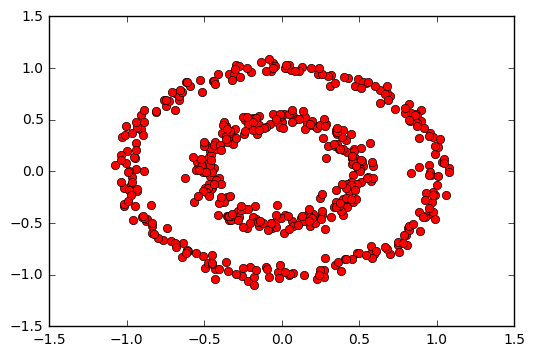

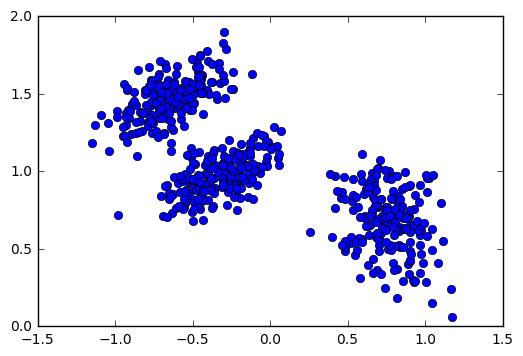

In [4]:
plt.plot(*zip(*circles), marker='o', color='r', ls='')
plt.show()

plt.plot(*zip(*blobs), marker='o', color='b', ls='')
plt.show()

In [5]:
def k_means(k, pts, get_indices=False, silent=True, tol=1e-5):
    N = len(pts)
    assert k <= N
    print("K=%d, N=%d" % (k, N))
    # pick random k points
    pos = set()
    while len(pos) < k:
        r = np.random.randint(N)
        pos.add(r)
    centroids = []
    for p in pos:
        centroids.append(tuple(pts[p]))
   
    change = float('inf')
    conv_tol = 1e-5
    itr, max_iters = 0, 100
    while change > tol and itr < max_iters:
        itr += 1
        # assign cluster to each point
        asgn = {}
        indices = {}
        for ct in centroids:
            asgn[ct] = []
            indices[ct] = []
        for idx, pt in enumerate(pts):
            mindist = float('inf')
            a = None
            for ct in centroids:
                dist = spatial.distance.cdist([ct], [pt])
                if dist < mindist:
                    mindist = dist
                    a = ct
            asgn[a].append(pt)
            indices[a].append(idx)

        # compute means of each cluster
        oldcentr = centroids
        centroids = []
        for ct, cluster in asgn.items():
            centroids.append(tuple(np.array(cluster).mean(axis=0)))
        dist_matrix = spatial.distance.cdist(oldcentr, centroids) 
        # has distance between each pair of {new, old} centroids
        # need the diagonal values
        change = dist_matrix.trace()
        if not silent:
            print("Movement in centroids", change)
    return indices if get_indices else asgn


K=2, N=500
K=3, N=500
K=5, N=500
K=2, N=600
K=3, N=600
K=5, N=600


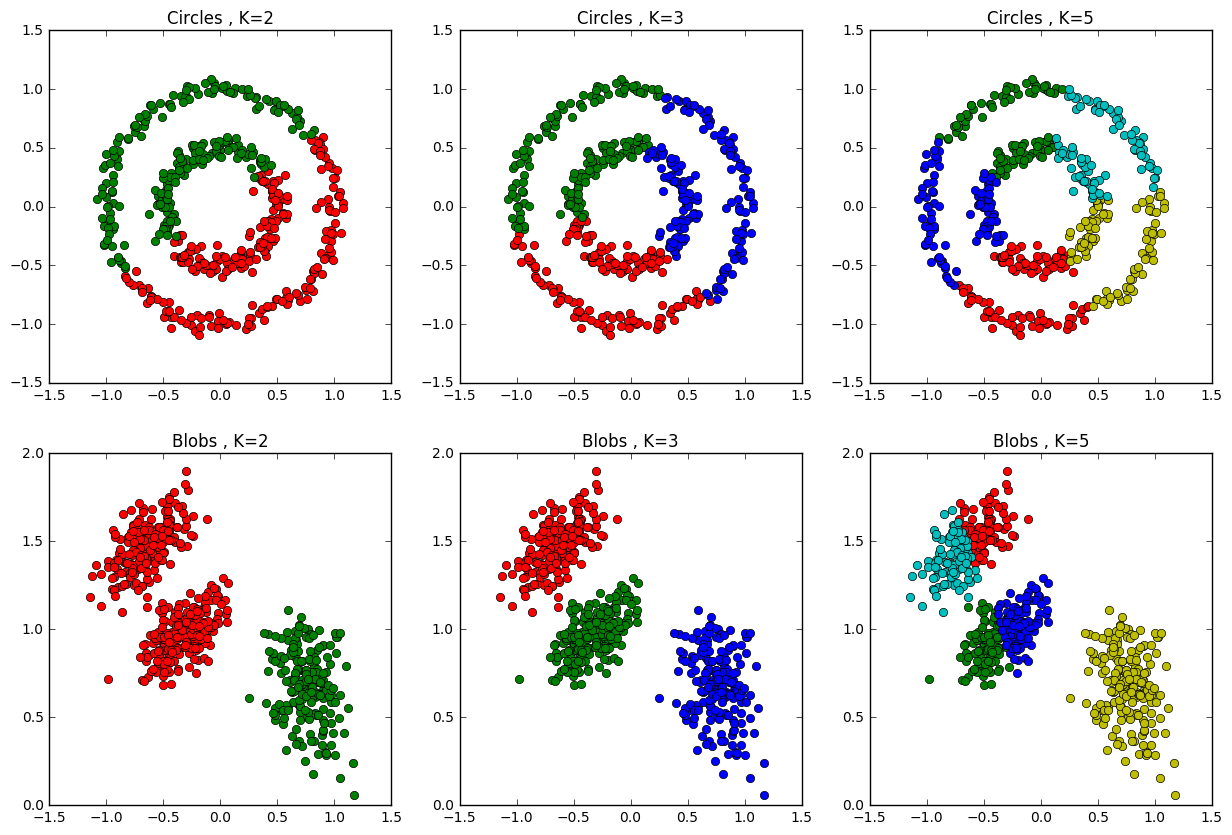

In [6]:
colors = ['r', 'g', 'b', 'y', 'c', 'k']
plt.figure(1, figsize=(15, 10))

ks = {2,3,5}
dss = {'Blobs': blobs, 'Circles': circles}
j = 1
for title, ds in dss.items():
    for k in ks:
        clstrs = k_means(k, ds)
        plt.subplot(2, 3, j)
        i = 0
        for cnt, cpts in clstrs.items():
            plt.plot(*zip(*cpts), marker='o', color=colors[i], ls='')
            i += 1
        plt.title("%s , K=%d" % (title, k))
        j += 1
        
plt.show()

# Kernel

## Feature Mapping

K=2, N=500


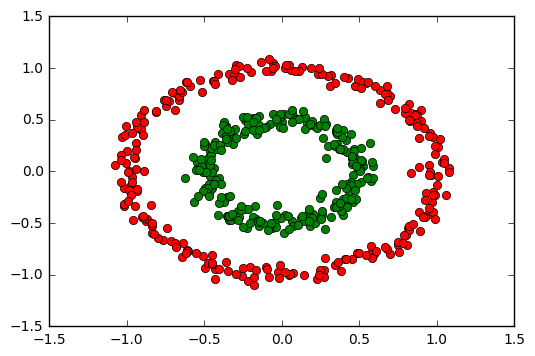

In [7]:
center = [0.0, 0.0]
newdim = sp.spatial.distance.cdist([center], circles).transpose()
clusters = k_means(2, newdim, get_indices=True)
i = 0
for cnt, cpts in clusters.items():
    cpts = map(lambda x: circles[x], cpts)
    plt.plot(*zip(*cpts), marker='o', color=colors[i], ls='')
    i += 1
plt.show()

## Kernel K Means

Kernel used :
 1 - (radius of x1) / (radius of x2)
 
 It ensures that the smaller radius goes to numerator and larger radius goes to denominator - for symmetry and bounding

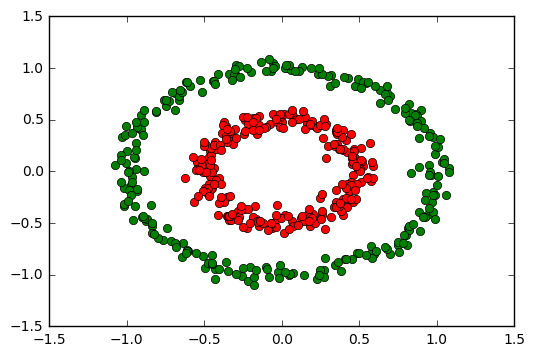

In [8]:
class KernelKMeans(object):
        
    def kernel_matrix(self, data, kernel_func):
        ''' Computes kernel matrix
        : params:
            data - data points
            kernel_func - kernel function
        :returns: nxn matrix
        '''
        n = data.shape[0]
        K = np.zeros((n,n), dtype=float)
        for i in range(n):
            for j in range(n):
                K[i,j] = kernel_func(data[i], data[j])
        return K

    def cluster(self, X, k, kernel_func, max_itr=100, tol=1e-3):
        '''
        Clusters the points
        :params:
            X - data points
            k - number of clusters
            kernel_func - kernel function that outputs smaller values for points in same cluster
        :returns: Nx1 vector of assignments
        '''
        # N
        N = X.shape[0]
        # NxN matrix from kernel funnction element wise
        K = self.kernel_matrix(X, kernel_func)
        # equal weightage to all
        cluster_weights = np.ones(N)        
        # Assignments : random assignments to begin with
        A = np.random.randint(k, size=N)

        for it in xrange(max_itr): # stuck up between 2 local minimas, abort after maxiter
            # N x k matrix that stores distance between every point and cluster center
            dist = self.compute_dist(K, k, A, sw=cluster_weights)
            oldA, A = A, dist.argmin(axis=1)
            # Check if it is conveged
            n_same = np.sum(np.abs(A - oldA) == 0)
            if 1 - float(n_same) / N < tol:
                print "Converged at iteration:", it + 1
                break
        return A

    def compute_dist(self, K, k, A, sw):
        """
        Computes Nxk distance matrix using kernel matrix
        : params:
            K - NxN kernel Matrix
            k - number of clusters
            A - Nx1 Assignments
            sw - sample weights
        : returns : Nxk distance matrix
        """
        dist = np.zeros((K.shape[0], k))
        for cl in xrange(k):
            mask = A == cl
            if np.sum(mask) == 0:
                raise Error("ERROR:cluster '%d' is empty. Looks like we cant make %d clusters" % (cl, k))
            N_ = sw[mask].sum()
            KK = K[mask][:, mask] 
            dist[:, cl] +=  np.sum(np.outer(sw[mask], sw[mask]) * KK / (N_*N_))          
            dist[:, cl] -= 2 * np.sum(sw[mask] * K[:, mask], axis=1) / N_
        return dist

def distance(x1, x2):
    '''Squared Eucledian distance between 2 points
    :params:
        x1 - point1
        x2 - point2
    '''
    return np.sum((x1 - x2) ** 2)

def circular_kernel(x1, x2, center=None):
    '''This kernel outputs lesser distance for the points that are from circumference
    :params:
        x1 - first point
        x2 - second point
        center - center of circle(default = origin (0,0,...))
    '''
    if center is None:
        center = np.zeros(len(x1))
    dist1 = distance(x1, center)
    dist2 = distance(x2, center)
    return 1.0 - min(dist1, dist2) / max(dist1, dist2)

clusters = KernelKMeans().cluster(circles, 2, circular_kernel)
for i in range(k):
    cpts = circles[clusters == i]
    plt.plot(*zip(*cpts), marker='o', color=colors[i], ls='')
    i += 1
plt.show()


# EM Algorithm with GMM

Converged:  38
Converged:  41
Converged:  41
Converged:  50
Converged:  44


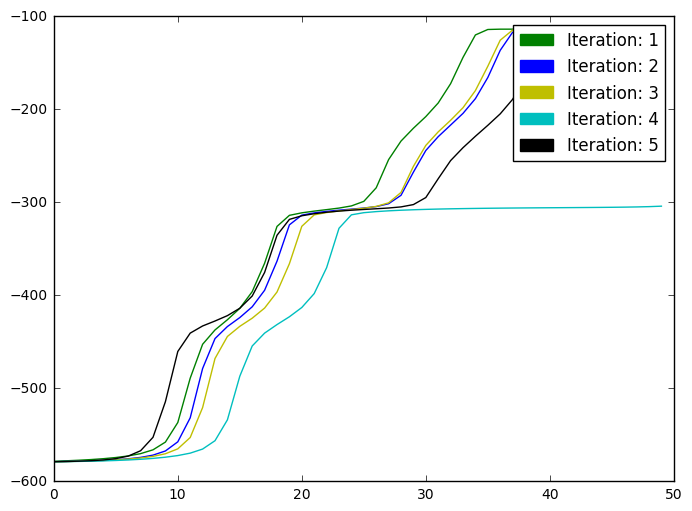

Best parameters: 
Mean: [array([-0.63945287,  1.47451928]), array([-0.32585149,  0.97129386]), array([ 0.75896022,  0.67976991])]
Covar: [array([[ 0.03595991,  0.01548585],
       [ 0.01548585,  0.01937635]]), array([[ 0.03603823,  0.01465402],
       [ 0.01465402,  0.01628829]]), array([[ 0.02717058, -0.00840047],
       [-0.00840047,  0.04044201]])]


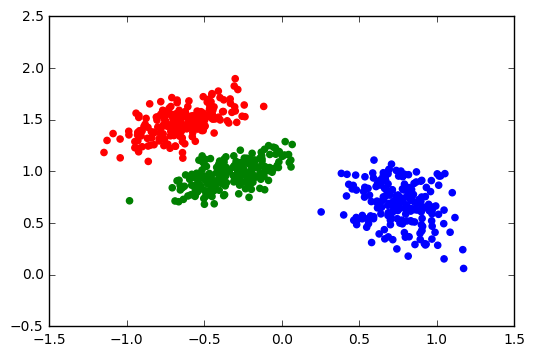

In [10]:
def multivar_gaussian_pdf(x, mu, covar):
    return multivariate_normal.pdf(x, mean=mu, cov=covar)

class EM_GMM(object):
    
    def __init__(self, data, k):
        self.data = data
        self.k = k
        self.N = data.shape[0]
        # theta param
        self.mean, self.cov, self.weight = [], [], []

        # random initialization
        A = np.random.randint(k, size=data.shape[0])
        for c in range(k):
            cpts = data[A == c]
            self.mean.append(np.mean(cpts, axis=0))
            self.cov.append(np.cov(np.array(cpts).transpose()))
            self.weight.append(1.0 * cpts.shape[0] / data.shape[0])

    def compute_gamma(self):
        gamma = np.zeros((self.N, self.k), dtype=float)
        for idx, pt in enumerate(data):
            pdf = []
            for ct in range(k):
                temp = multivar_gaussian_pdf(pt, self.mean[ct], self.cov[ct])
                pdf.append(temp * self.weight[ct])
            gamma[idx] = np.array(pdf) / sum(pdf)
        return gamma

    def update_theta(self, P):
        weights = P.sum(axis=0)/P.sum()
        means = []
        covs = []
        for i in range(self.k):
            nr_mu = (P[:, i:i+1] * self.data).sum(axis=0)
            dr_mu = P[:, i].sum(axis=0)
            pt_mu = nr_mu / dr_mu
            means.append(pt_mu)

        for i in range(self.k):
            nr_cov = (P[:, i:i+1] * (self.data - means[i])).transpose().dot(self.data - means[i])
            dr_cov = P[:, i].sum(axis=0)
            covs.append(nr_cov / dr_cov)
        self.mean=  means
        self.cov = covs
        self.weight = weights

    def log_likelihood(self):
        log_sum = 0.
        for _, pt in enumerate(self.data):
            row_sum = []
            for ct in range(self.k):
                p_X_given_N = multivar_gaussian_pdf(pt, self.mean[ct], self.cov[ct])
                p_N = self.weight[ct]
                joint = p_N * p_X_given_N
                row_sum.append(joint)
            res = sum(row_sum)
            log_sum += math.log(res)
        return log_sum

    def gmm(self, max_itr = 50):
        ll = []
        for itr in range(max_itr):
            old_means = self.mean # used for convergance test
            gamma = self.compute_gamma()
            self.update_theta(gamma)
            ll.append(self.log_likelihood())
            if np.sum(np.abs(np.array(self.mean) - np.array(old_means))) < 1e-3:
                break
        return gamma, ll

data = blobs
max_ll = 0
plt.figure(1, figsize=(8, 6))
legends = []
k = 3
for i in range(1,6):
    em = EM_GMM(data, k)
    gamma, ll = em.gmm()
    if ll >= max_ll:
        best_gamma = gamma
        best = em
        max_ll = ll

    print "Converged: ", len(ll)
    plt.plot(range(len(ll)), ll , '-', color=colors[i])
    legends.append(mpatches.Patch(color=colors[i], label='Iteration: %d' % i))

plt.legend(handles=legends)
plt.show()

idx = best_gamma.argmax(axis=1)
print "Best parameters: "
print "Mean:", best.mean
print "Covar:", best.cov
plt.scatter(data[:,0], data[:,1],  color=[colors[i] for i in idx] )
plt.show()
